<a href="https://colab.research.google.com/github/mahmoudmastouri/Portfolio-Risk-in-Multiple-Frequencie/blob/master/03_Eigenfiltering_of_Noise_in_estimated_correlation_matrix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Portfolio Risk in Multiple frequencies (part II)

# General Definitions and functions

In [ ]:
!pip3 install yfinance

In [ ]:
import numpy as np
# There's an issue with pandas_datareader while working on collab
#import pandas_datareader as pdr
import yfinance as yf
import datetime as dt
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [ ]:
%matplotlib inline

In [ ]:
def prepare_portfolio(tickers,start,end = None):
    returns = pd.DataFrame()
    for ticker in tickers:
      end = end if end != None else dt.datetime.now().strftime("%Y-%m-%d")
      data = yf.download(ticker, start = start, end=end)
      data = pd.DataFrame(data)
      data[ticker] = data['Adj Close'].pct_change()
      if returns.empty:
          returns = data[[ticker]]
      else:
          returns = returns.join(data[[ticker]], how = 'outer' )
    return returns

# Eigenfiltering of Noise in estimated correlation matrix
## Gather Data

In [ ]:
tickers = ["AAPL", "JPM", "WMT", "TGT", "MSFT", "AMGN", "^NDX", "SPY"]
start = dt.datetime(2015,1,1).strftime("%Y-%m-%d")
end = dt.datetime(2020,12,12).strftime("%Y-%m-%d")
daily_returns = prepare_portfolio(tickers, start, end)
daily_returns = daily_returns.dropna()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


## Finding Eigenbalues and Eigenvectors
<b>$ C = VΛV^T $</b>
</br></br>
<b>$Λ$</b>$=diag(λ_1,λ_2,...,λ_N)$, where the $k^{th}$ element of the diagonal matrix $Λ$ is the kth
eigenvalue $λ_k$.</br></br>
<b>$V$</b>$=diag(v_1,v_2,...,v_N)$, where $v_k$ is an N-by-1 eigenvector corresponding 

In [ ]:
C = daily_returns.corr(method='pearson')
C_eigenvalues, C_eigenvectors  = np.linalg.eig(C)

## Identifying the number of eigenvectors L

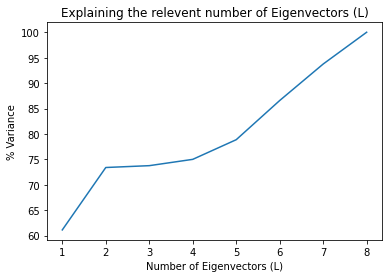

In [ ]:
variance_explained = []
eigen_sum = sum(C_eigenvalues)
for i in C_eigenvalues:
  variance_explained.append((i/eigen_sum)*100)
cumulative_variance_explained = np.cumsum(variance_explained)
plt.figure()
plt.plot(range(1,len(C_eigenvalues)+1), cumulative_variance_explained)
plt.xlabel("Number of Eigenvectors (L)")
plt.ylabel("% Variance")
plt.title("Explaining the relevent number of Eigenvectors (L)")
plt.show()

## Using  λmax=0.75

In [ ]:
lambda_max = 0.75

Picking the minimun nember of cumulative variance that satisfies $ λ_k ≥ λ_{max}$ and $ L ≪ N$

In [ ]:
L = len([i for i in range(len(cumulative_variance_explained)) if cumulative_variance_explained[i] <= lambda_max*100])
L = L if L>0 else 1
print("L = ",L)

L =  3


## Estimating $\tilde{C}$
$ \tilde{C} = \sum_{k=1}^{L}λ_kv_kv_k^T+$<b>$E$</b>

### Estimating $Ε$
$[E]_{ij}=ϵ_{ij}=\{_{0, i≠j }^{1- \sum_{k=1}^{L}λ_kv_i^{(k)}v_j^{(k)}, i=j  }$

In [ ]:
Lambda_eig = C_eigenvalues
V_eig = C_eigenvectors

In [ ]:
epsilon = np.zeros_like(C)
for i in range(epsilon.shape[0]):
  for j in range(epsilon.shape[1]):
    if j==i:
      epsilon[i,i] = 1
      for k in range(L):
        epsilon[i,i] -= Lambda_eig[k]*V_eig[i,k]*V_eig[j,k]

### Calculation of $ [\tilde{C}]_{ij} $
$ [\tilde{C}]_{ij} = [\tilde{p}]_{ij} = \sum_{k=1}^{L}λ_kv_i^{(k)}v_j^{(k)}$, where L is the number of selected factors (eigenvalues) satisfying $ λ_k ≥ λ_{max}$ and $ L ≪ N$.

In [ ]:
  C_estimated = np.zeros_like(C)
  for i in range(C.shape[0]):
    for j in range(C.shape[1]):
      for k in range(L):
        C_estimated[i,j] = Lambda_eig[k]*V_eig[k,i]*V_eig[k,j] + epsilon[i,j]

# Risk Estimation $\tilde{σ}^2_p$

$ \tilde{σ}_{p}^2 = \sum_{k=1}^{L}λ_k( \sum_{i=1}^{N}q_iv_i^kσ_i)^2 + \sum_{i=1}^{N}ϵ_{ii}q_i^2σ_i^2 $ 


In [ ]:
n_portfolios = 1000
N = len(tickers)
qs = np.array([  np.random.normal(0, 1, N) for _ in range(n_portfolios) ])
Sigma = np.diag(np.std(daily_returns))
simga_p = np.array([ qs[i,:] @ Sigma.T @ C_estimated @ Sigma @ (qs[i,:]).T for i in range(n_portfolios)])
mu = np.array(np.mean(daily_returns))
ones = np.ones((N,))
mu_p = qs @ mu

 ## Using $q$ ~ $N(1,0)$

In [ ]:
sigma_filtered = np.zeros_like(simga_p)
for p in range(n_portfolios):
  temp1 = 0
  temp2 = 0
  for k in range(L):
    temp1_1 = 0
    for i in range(N):
      temp1_1 += (qs[p,i]*V_eig[k,i]*simga_p[p])**2
    temp1_1 *=Lambda_eig[k]
    temp1 +=temp1_1
  for i in range(N):
    temp2 += epsilon[i,i]*((qs[p,i])**2)*(simga_p[p])**2
  sigma_filtered[p] += temp1 + temp2

In [ ]:
def plot_sigmas(mu_p, sigma_n,sigma_f):
  sharpe_arr = mu_p/sigma_n
  sharpe_arr_filtered = mu_p/sigma_f
  plt.figure()
  plt.scatter(sigma_f, mu_p, c=sharpe_arr_filtered, edgecolors='red', marker=".")
  plt.scatter(sigma_n, mu_p, c=sharpe_arr, edgecolors='blue',marker=".")
  plt.xlabel('µ')
  plt.ylabel('σ')
  plt.show()

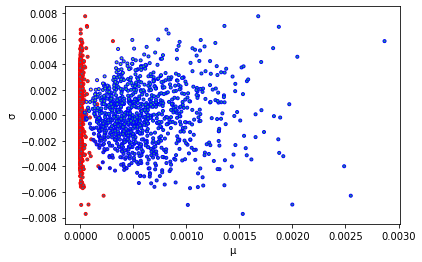

In [ ]:
plot_sigmas(mu_p, simga_p, sigma_filtered)

## Using $q = q^*$

In [ ]:
q_stars = []
for i in range(n_portfolios):
  first = np.linalg.det([[mu_p[i], ones.T@np.linalg.inv(C_estimated)@mu], [1, ones.T@np.linalg.inv(C_estimated)@ones]])
  second = np.linalg.det([ [mu.T@np.linalg.inv(C_estimated)@mu, mu_p[i]], [mu.T@np.linalg.inv(C_estimated)@ones, 1] ])
  third = np.linalg.det([ [mu.T@np.linalg.inv(C_estimated)@mu, ones.T@np.linalg.inv(C_estimated)@mu], [mu.T@np.linalg.inv(C_estimated)@ones, ones.T@np.linalg.inv(C_estimated)@ones] ])
  q_star = ( first*np.linalg.inv(C_estimated)@mu + second*np.linalg.inv(C_estimated)@ones)/third
  q_stars.append(q_star)
q_stars = np.array(q_stars)
simga_p = np.array([ q_stars[i,:] @ Sigma.T @ C_estimated @ Sigma @ (q_stars[i,:]).T for i in range(n_portfolios)])

In [ ]:
mu_p_opt = q_stars @ mu
simga_p_opt = np.array([ q_stars[i,:] @ Sigma.T @ C @ Sigma @ (q_stars[i,:]).T for i in range(n_portfolios)])

In [ ]:
sigma_filtered_q_star = np.zeros_like(simga_p)
for p in range(n_portfolios):
  temp1 = 0
  temp2 = 0
  for k in range(L):
    temp1_1 = 0
    for i in range(N):
      temp1_1 += (q_stars[p,i]*V_eig[k,i]*simga_p[p])**2
    temp1_1 *=Lambda_eig[k]
    temp1 +=temp1_1
  for i in range(N):
    temp2 += epsilon[i,i]*((q_stars[p,i])**2)*(simga_p[p])**2
  sigma_filtered_q_star[p] += temp1 + temp2  

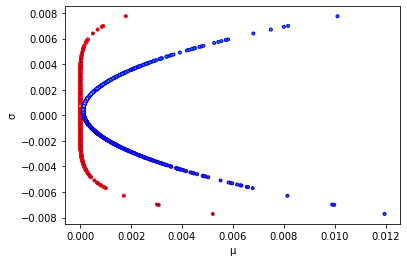

In [ ]:
plot_sigmas(mu_p_opt, simga_p_opt, sigma_filtered_q_star)

In [ ]:
sigma_filtered_q_star